## Introduction:

In this notebook we'll try to understand brain activity relates to external signals, by analysing the results of an experiment where a fish was exposed to a visual stimulus while we recorded its brain activity and tail movements.
As a reminder this is a schematic of the experimental setup:

![setup](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/experimental_setup_danionella.png)

We'll start by looking at correlations with a single external signal, then we'll use multiple linear regression to see how different signals are encoded in the brain and finally we'll try to decode external signals from brain activity.

Some parts are missing and you'll have to code them yourself, they are highlighted with a keyboard symbol ⌨️.
At any time, you can run `thing?` to get the documentation for `thing`. Typically, this is useful if `thing` is a function, and you need to know what are its parameters and/or what it does. 

Let's get started by importing the necessary libraries:

### Import libraries and dataset:

In [1]:
%matplotlib widget
%matplotlib inline
dpi=100

In [2]:
%load_ext autoreload
%autoreload 2

Import libraries:

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from Helper_Functions.accessing_data import h5tree_view
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve
from scipy.interpolate import interp1d
from sklearn.preprocessing import scale
from Helper_Functions.OrthoViewer import OrthoAxes
from Helper_Functions.plotting_functions import plot_dff_traces,plot_dff_raster,plot_brain_layers,plot_brain_projections,plot_coefficients,plot_neurons_per_label
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score
import itertools

Import hdf5 file and save arrays to local variables:

In [4]:
#!gdown --folder 1k21VhLoonOnoxxXyswrmE45VIB4FF00n

In [5]:
filepath = 'content/banyuls_data/fish1_different_speeds.hdf5'
file=h5py.File(filepath, 'r')

In [6]:
h5tree_view(file)

. content/banyuls_data/fish1_different_speeds.hdf5
├── 📁brain
│   ├── 🔢acquisition_rate ⚙️()float64
│   ├── 🔢coordinates ⚙️(3, 30971)float64
│   ├── 🔢fluorescence ⚙️(30971, 481)float64
│   ├── 🔢times ⚙️(481,)float64
├── 📁stimulus
│   ├── 🔢T ⚙️(481,)float64
│   ├── 🔢acquisition_rate ⚙️()float64
│   ├── 🔢direction ⚙️(14362,)float64
│   ├── 🔢speed ⚙️(14362,)float64
│   ├── 🔢times ⚙️(14362,)float64
├── 📁tail
│   ├── 🔢acquisition_rate ⚙️()float64
│   ├── 🔢coordinates ⚙️(36107, 11, 2)float64
│   ├── 🔢deflection ⚙️(36107,)float64
│   ├── 🔢deflection_mean ⚙️(36107,)float64
│   ├── 🔢deflection_std ⚙️(36107,)float64
│   ├── 🔢forward_thrust ⚙️(36107,)float64
│   ├── 🔢side_thrust ⚙️(36107,)float64
│   ├── 🔢times ⚙️(36107,)float64


In [7]:
brain_times=file['brain/times'][:]
dff=file['brain/fluorescence'][:]
coords=file['brain/coordinates'][:]

stimulus_speed=file['stimulus/speed'][:]
stimulus_times=file['stimulus/times'][:]
stimulus_T=file['stimulus/T'][:]

tail_times=file['tail/times'][:]
deflection=file['tail/deflection'][:]
forward_thrust=file['tail/forward_thrust'][:]

In [8]:
file.close()

## Correlation between neural activity and external signals:

### Preprocessing the signal:

Let's start by finding neurons whose activity is correlated with tail movements.  Here we plot a measure of the strength of the tail movements which captures the forward thrust, the higher the value the stronger the force the fish is exerting to move forward.

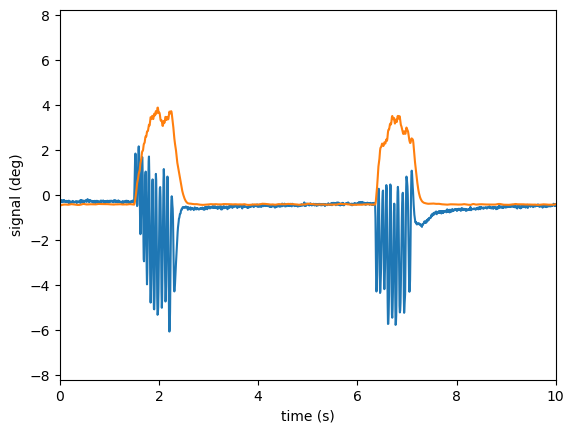

In [10]:
t1=0
t2=10 #brain_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,scale(deflection))
ax.plot(tail_times,scale(forward_thrust))
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
#ax.set_ylim(0,100)
plt.show()

The fluorescence that we observe is a indicator of neural activity, it's a meausure of the concentration of calcium ions inside the neuron, which in turn is correlated with its firing rate.  Because of the unbinding kinetics of the calcium indicator, the fluorescence decays exponentially following an action potential with a characteristic time of $\tau \simeq 3$ s.

Fluorescence traces can be seen as a convolution of the spike train with a calcium impulse response function, which we'll take to be a simple exponential.

Because of this, if we want to compare our behavioral signal with the fluorescence traces, we'll have to convolve it with an exponential kernel of the form: $H(t) e^{-t/\tau}$

We start by defining the exponential kernel for the convolution, note that $t=0$ corresponds to the center of the array:

In [11]:
tau=3
T=10*tau
tail_acquisition_rate=1/np.mean(np.diff(tail_times))
n_samples=int(T*tail_acquisition_rate)
kernel_times=np.linspace(-n_samples/tail_acquisition_rate,n_samples/tail_acquisition_rate,2*n_samples+1)
kernel=np.exp(-kernel_times/tau)
kernel[kernel_times<0]=0

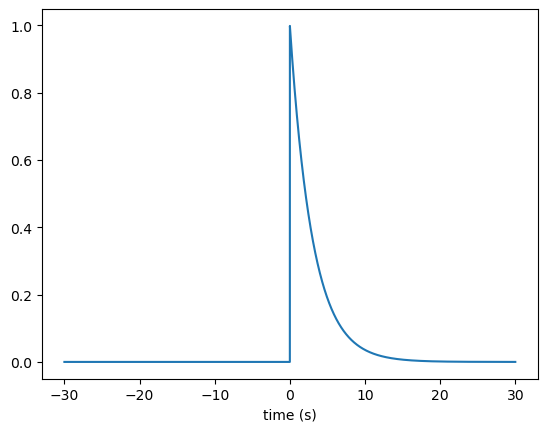

In [12]:
fig,ax=plt.subplots(dpi=dpi)
ax.plot(kernel_times,kernel)
ax.set_xlabel('time (s)')
plt.show()

Then we can perform the convolution:

In [14]:
forward_thrust_conv=convolve(forward_thrust,kernel,mode='same')/tail_acquisition_rate

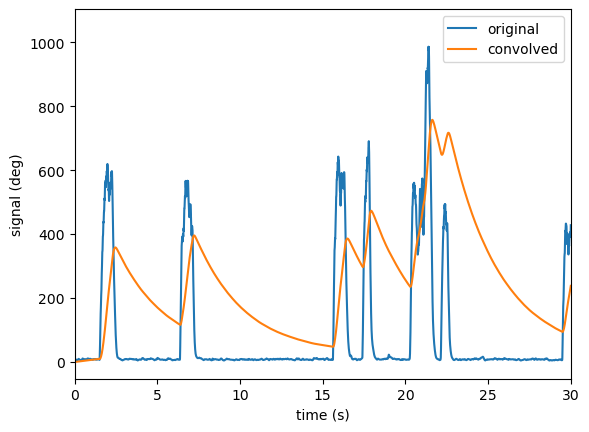

In [15]:
t1=0
t2=30 #brain_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,forward_thrust,label='original')
ax.plot(tail_times,forward_thrust_conv,label='convolved')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

Finally we have to resample the array at the same times where the fluorescence was measured, to do so we'll perform a linear interpolation:

In [16]:
forward_thrust_conv_interp_f=interp1d(tail_times,forward_thrust_conv,kind='linear',fill_value='extrapolate')
signal_forward=forward_thrust_conv_interp_f(brain_times)

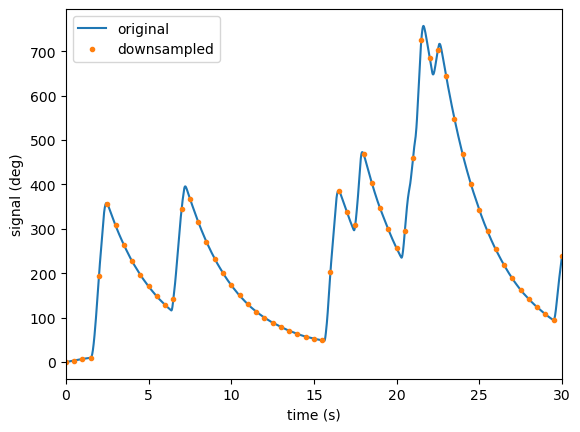

In [18]:
t1=0
t2=30 #brain_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(tail_times,forward_thrust_conv,label='original')
ax.plot(brain_times,signal_forward,'.',label='downsampled')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

We can define a function that does all this in once to make this preprocessing easier in the future:

In [19]:
def convolve_and_interpolate(signal,signal_times,output_times,tau=3,kernel_size=10):
    """Convolve signal with the calcium impulse response function and resample it at different times using linear interpolation.

    Parameters :
    ------------
    signal : 1d array
        values of the time series
        
    signal_times : 1d array
        timepoints of the time series

    output_times : 1d array
        timepoints at which we want to resample the signal
    
    tau : integer
        characteristic decay time of the exponential kernel in seconds
        default : 3
    
    kernel_size : integer
        size of the kernel in units of tau
        default : 10  
        
    Return :
    --------
    signal_conv_interp : 1d array
        resampled values of the convolved time series
    """
    acquisition_rate=1/np.mean(np.diff(signal_times))
    n_samples=int(kernel_size*tau*acquisition_rate)
    kernel_times=np.linspace(-n_samples/acquisition_rate,n_samples/acquisition_rate,2*n_samples+1)
    kernel=np.exp(-kernel_times/tau)
    kernel[kernel_times<0]=0
        
    signal_conv=convolve(signal,kernel,mode='same')/acquisition_rate
    signal_conv_interp_f=interp1d(signal_times,signal_conv,kind='linear',fill_value='extrapolate')
    signal_conv_interp=signal_conv_interp_f(output_times)
    return signal_conv_interp

### Calculating correlations:

As a measure of correlation we can calculate the covariance between the preprocessed tail amplitude and the neural fluorescence traces.  

$$Cov(x,y)=\overline{(x-\bar{x})\cdot(y-\bar{y})}$$

Regions where both signals are larger or smaller than their averages give positive contibutions, whereas regions where one is larger and the other is smaller give negative contributions.  This way correlated signals we'll have a positive covariance, anticorrelated signals a negative covariance, and uncorrelated signals a covariance that is close to zero (how much?).

The fluorescence traces are already centered around 0:

In [20]:
def calculate_covariance(signal,dff):
    """Calculate covariance values between signal and rescaled fluorescence for all neurons.

    Parameters :
    ------------
    signal : 1d array
        external signal, shape (n_timepoints)
        
    dff : 2d array
        rescaled fluorescence traces for all neurons, shape (n_neurons,n_timepoints)
        
    Return :
    --------
    covariance : 1d array
        covariance values
    """
    n_neurons=len(dff)
    signal=signal-np.mean(signal)
    dff=dff-np.mean(dff,axis=1).reshape(-1,1)
    covariance=np.zeros(n_neurons)
    for i in range(n_neurons):
        covariance[i]=np.mean(signal*dff[i])
    
    return covariance

In [23]:
covariance_forward=calculate_covariance(signal_forward,dff)

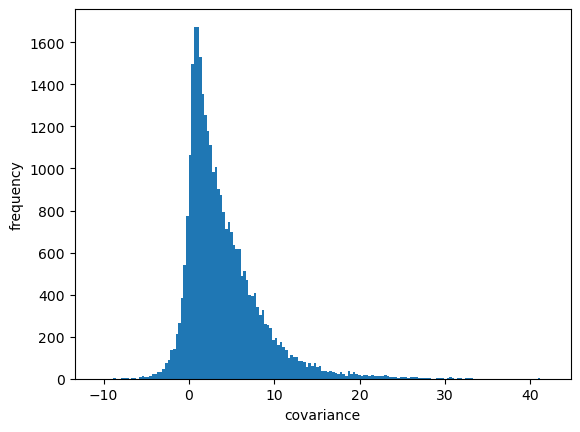

In [24]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(covariance_forward,bins='auto')
ax.set_xlabel('covariance')
ax.set_ylabel('frequency')
plt.show()

### Calculating statistical significance:

How do we know if a covariance value is significantly larger than zero?
We need a way to define a threshold above which covariances are satistically significant.

We would like to know the distribution of covariances in the case where the two signals are uncorrelated.
We can estimate it with a method called bootstrapping, it consists in resampling our signal in order to create new signals with the same statistics.
As we're working with time series, adjacent samples are not independent but correlated in time, thus we're going to resample blocks of consecutive samples in order to preserve the structure on short times.

We choose a method called stationary bootstrap, in which the size of the blocks is randomized as well.

In [25]:
def stationary_bootstrap(signal,average_block_size=60):
    """resample a time series using stationary bootstrap, it samples with replacement random blocks of sizes following a geometric distribution.

    Parameters :
    ------------
    signal : array
        original time series, the first dimension corresponds to time, shape (n_timepoints,...)
        
    average_block_size : integer
        average number of values in a block during resampling
        default : 60
        
    Return :
    --------
    resampled_signal : array
        bootstrapped time series
    """
    l=len(signal)
    p=1/average_block_size
    resampled_signal=np.zeros_like(signal)
    j=np.random.randint(l)
    resampled_signal[0]=signal[j]
    for i in range(1,l):
        if np.random.random()<1-p:
            j=(j+1)%l
        else:
            j=np.random.randint(l)
        resampled_signal[i]=signal[j]
    return resampled_signal

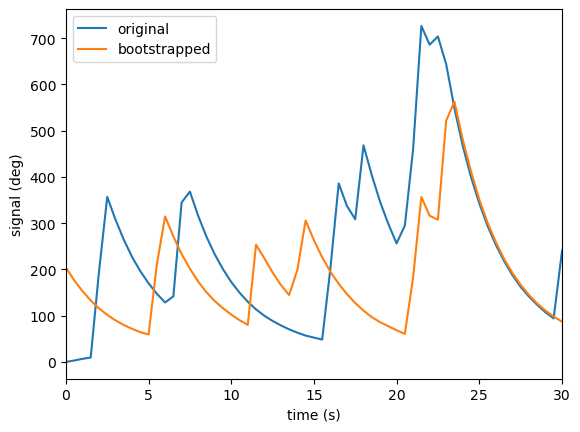

In [26]:
average_block_duration=30
brain_acquisition_rate=1/np.mean(np.diff(brain_times))
signal_forward_resampled=stationary_bootstrap(signal_forward,average_block_duration*brain_acquisition_rate)
t1=0
t2=30 #brain_times[-1]
fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,signal_forward,label='original')
ax.plot(brain_times,signal_forward_resampled,label='bootstrapped')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

Now we can create a null distribution of covariances using the bootstrapped signals, we expect the covariance to follow this distribution for neural activity that is independent of the behavioral signal:

In [27]:
def calculate_covariance_bootstrap(signal,dff,n_resamples=20,average_block_size=60):
    """Calculate covariance values between resampled signal using stationary bootstrap and rescaled fluorescence for all neurons.

    Parameters :
    ------------
    signal : 1d array
        external signal, shape (n_timepoints)
        
    dff : 2d array
        rescaled fluorescence traces for all neurons, shape (n_neurons,n_timepoints)
    
    n_resamples: integer
        number of resampled signals used for calculating covariance
        default : 20
        
    average_block_size : integer
        average number of values in a block during resampling
        default : 60
        
    Return :
    --------
    covariance_bootstrap : 1d array
        covariance values
    """
    n_neurons=len(dff)
    covariance_bootstrap=np.zeros(n_resamples*n_neurons) 
    
    for n in range(n_resamples):
        signal_resampled=stationary_bootstrap(signal,average_block_size)
        covariance_bootstrap[n*n_neurons:(n+1)*n_neurons]=calculate_covariance(signal_resampled,dff)
        
    return covariance_bootstrap

In [28]:
covariance_forward_bootstrap=calculate_covariance_bootstrap(signal_forward,dff)

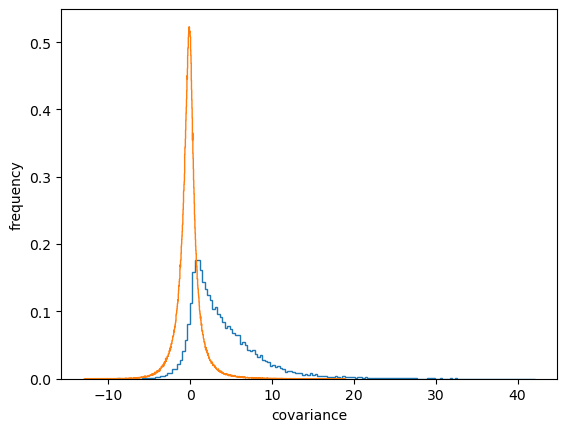

In [29]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(covariance_forward,bins='auto',histtype='step',density=True,label='original')
ax.hist(covariance_forward_bootstrap,bins='auto',histtype='step',density=True,label='bootstrapped')
ax.set_xlabel('covariance')
ax.set_ylabel('frequency')
plt.show()

Now that we have an estimate of the null distribution, we can calculate the p-value associated to a certain covariance, it's the probability of obtaining an even larger value of covariance according to the null distribution:

In [30]:
def calculate_pvalue(statistic,statistic_bootstrap):
    """Calculate p-values for a set of statistics, based on a null distribution estimated with a set of bootstrapped statistics.

    Parameters :
    ------------
    statistic : 1d array
        values of a statistic for which we want to calculate the p-value
        
    statistic_bootstrap : 1d array
        bootstrapped values of a statistic from which we estimated the null distribution
        
    Return :
    --------
    pvalue : 1d array
        p-values
    """
    statistic_bootstrap_sorted=np.sort(statistic_bootstrap)
    statistic_bootstrap_sorted=np.append(statistic_bootstrap_sorted,statistic_bootstrap_sorted[-1])
    probability_of_smaller_values=np.arange(len(statistic_bootstrap_sorted))/(len(statistic_bootstrap_sorted)-1)
    empirical_distribution_function=interp1d(statistic_bootstrap_sorted,probability_of_smaller_values,kind='next',fill_value='extrapolate')
    pvalue=np.zeros(len(statistic))
    for i in range(len(statistic)):
        pvalue[i]=1-empirical_distribution_function(statistic[i])
        
    return pvalue

In [32]:
pvalue=calculate_pvalue(covariance_forward,covariance_forward_bootstrap)

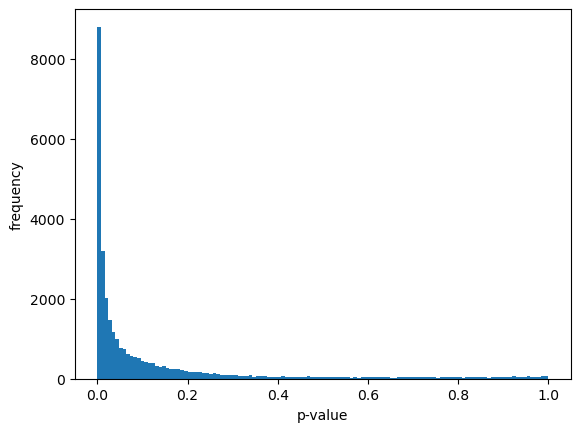

In [33]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(pvalue,bins='auto')
ax.set_xlabel('p-value')
ax.set_ylabel('frequency')
plt.show()

Normally, one would consider as statistically significant a covariance value for which the p-value is smaller than a certain threshold fixed before the experiment.  This would be ok for a single neuron, but in our case we have to be more careful as we're testing multiple hypothesis simultaneously.

What we can do is to control the false discovery rate, expected fraction of false positives, neurons that are incorrectly classified as significantly correlated.  We can implement the Benjamini–Hochberg procedure, which ensures that the false discovery rate is smaller than a given threshold $\alpha$.  If we're testing $m$ hypotheses we have to sort the p-values in increasing order and find the largest index $k$ such that $P_k \leq \frac{k}{m}\alpha$.  Then we  can reject the null hypothesis of uncorrelated signals for the $k$ neurons with the smallest p-values.

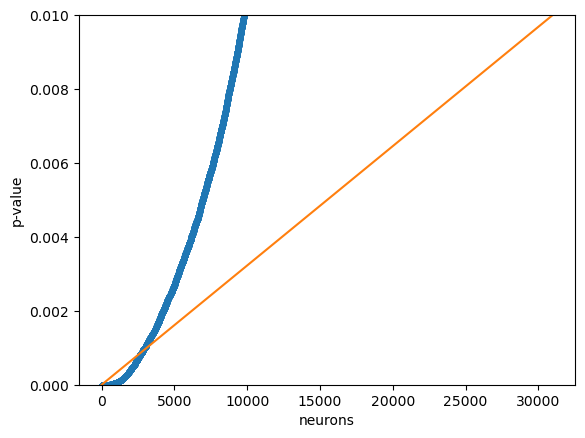

In [34]:
alpha_bh=0.01
sorted_pvalues=np.sort(pvalue)
line_bh=(np.arange(len(pvalue))+1)/len(pvalue)*alpha_bh

fig,ax=plt.subplots(dpi=dpi)
ax.plot(sorted_pvalues,'.')
ax.plot(line_bh)
ax.set_ylim(0,alpha_bh)
ax.set_xlabel('neurons')
ax.set_ylabel('p-value')
plt.show()

The number of significantly correlated neurons according to the Benjamini-Hochberg procedure is:

We can extract the indices of the significantly correlated neurons as follows:

In [35]:
def find_significant_neurons(statistic,statistic_bootstrap,alpha_bh=0.01):
    """Calculate p-values and test if they are significant using the Benjamini-Hochberg procedure.

    Parameters :
    ------------
    statistic : 1d array
        values of the statistic for which we obtained the p-values

    statistic_bootstrap : 1d array
        bootstrapped values of a statistic from which we estimated the null distribution
        
    Return :
    --------
    indices_thr : 1d array
        indices of neurons for which we reject the null hypothesis sorted with decreasing value of the statistic    

    mask : 1d array
        boolean array which gives True on the indices of neurons for which we reject the null hypothesis
    """
    pvalue=calculate_pvalue(statistic,statistic_bootstrap)
    
    sorted_pvalues=np.sort(pvalue)
    line_bh=(np.arange(len(pvalue))+1)/len(pvalue)*alpha_bh

    indices_inequality=np.where(sorted_pvalues<=line_bh)[0]
    if len(indices_inequality)==0:
        n_rejected_neurons=0
    else:
        n_rejected_neurons=np.max(indices_inequality)+1

    indices_sorted=np.argsort(-statistic)
    indices_thr=indices_sorted[:n_rejected_neurons]
    mask=np.zeros(len(dff))
    mask[indices_thr]=1
    mask=mask.astype(bool)

    return indices_thr,mask

In [36]:
indices_forward,mask_forward=find_significant_neurons(covariance_forward,covariance_forward_bootstrap)

In [37]:
len(indices_forward)

2798

### Plotting activity and position of significantly correlated neurons:

We can plot the fluorescence traces of the significantly correlated neurons together with the behavioral signal:

In [38]:
plot_dff_traces(signal_forward,brain_times,indices_forward,dff)

interactive(children=(IntSlider(value=0, description='neuron', max=2797), Output()), _dom_classes=('widget-int…

We can look at all the fluorescence traces together by encoding them in the lightness values of the pixels in an image, the result is called a raster plot:

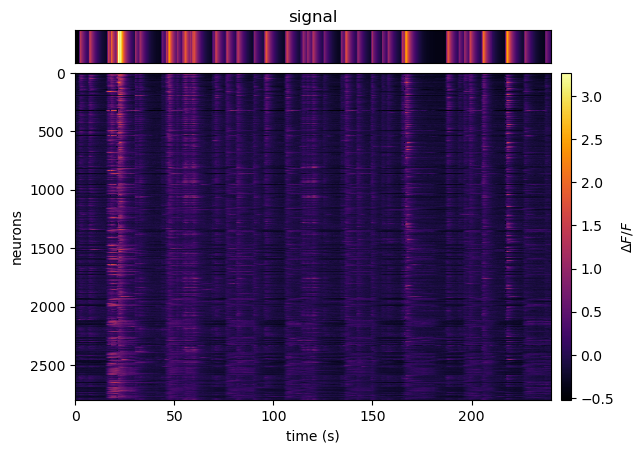

In [39]:
plot_dff_raster(signal_forward,brain_times,indices_forward,dff)

We can plot the positions of the neurons that are significantly correlated, with the opacity of the points proportional to the covariance:

In [40]:
plot_brain_layers(coords,mask_forward,covariance_forward)

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

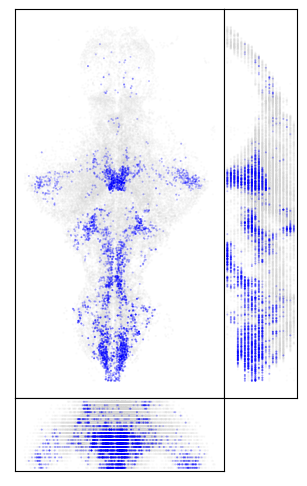

In [41]:
plot_brain_projections(coords,mask_forward,covariance_forward)

In [42]:
n_bins=10
bin_edges=np.histogram(signal_forward,n_bins)[1]
bin_centers=(bin_edges[1:]+bin_edges[:-1])/2

In [47]:
dff_mean=np.zeros(n_bins)
dff_std=np.zeros(n_bins)

for i in range(n_bins):
    dff_mean[i]=dff[indices_forward][:,(signal_forward>bin_edges[i])&(signal_forward<bin_edges[i+1])].mean()
    dff_std[i]=dff[indices_forward][:,(signal_forward>bin_edges[i])&(signal_forward<bin_edges[i+1])].std()

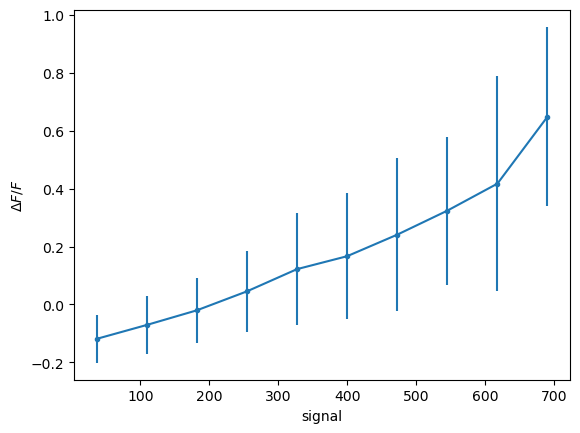

In [48]:
fig,ax=plt.subplots(dpi=dpi)
ax.errorbar(bin_centers,dff_mean,dff_std,fmt='.-')
ax.set_xlabel('signal')
ax.set_ylabel(r'$\Delta F/F$')
plt.show()

### Correlation with stimulus speed:

We can also look for neurons whose activity is correlated with the speed of the external stimulus:

In [49]:
stimulus_speed_conv_interp=convolve_and_interpolate(stimulus_speed,stimulus_times,brain_times)
signal_speed=scale(stimulus_speed_conv_interp)

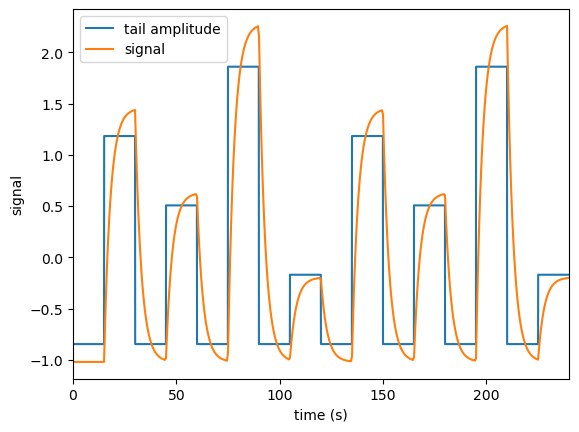

In [50]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(stimulus_times,scale(stimulus_speed),label='tail amplitude')
ax.plot(brain_times,signal_speed,label='signal')
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

In [56]:
covariance_speed=calculate_covariance(signal_speed,dff)
covariance_speed_bootstrap=calculate_covariance_bootstrap(signal_speed,dff)
indices_speed,mask_speed=find_significant_neurons(covariance_speed,covariance_speed_bootstrap)

In [57]:
len(indices_speed)

735

In [58]:
plot_dff_traces(signal_speed,brain_times,indices_speed,dff)

interactive(children=(IntSlider(value=0, description='neuron', max=734), Output()), _dom_classes=('widget-inte…

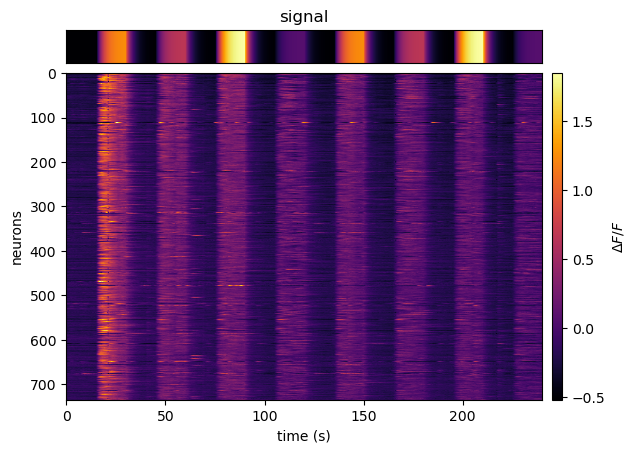

In [59]:
plot_dff_raster(signal_speed,brain_times,indices_speed,dff)

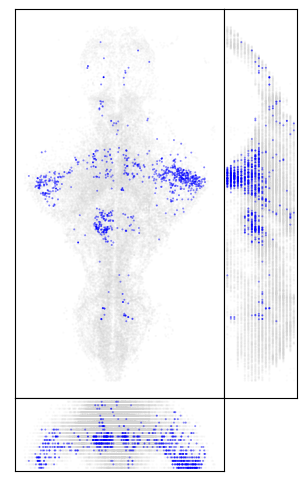

In [61]:
plot_brain_projections(coords,mask_speed,covariance_speed)

## Multiple linear regression:

We've seen how to find neurons whose activity is correlated with a single signal, for example some feature of a behavior or of an external stimulus.

But what about neurons that encode multiple different signal?

We can use multiple linear regression to find how different external signals are encoded in the brain.

We're going to fit neural activity independently for each neuron with a linear combination of such signals, called regressors.

We define three regressors for the tail movement, one corresponding to forward thrust, and two others for left and right thrust.

In [321]:
signal_forward=convolve_and_interpolate(tail_forward_thrust,tail_times,brain_times)

right_thrust=np.copy(tail_side_thrust)
right_thrust[right_thrust<0]=0
signal_right=convolve_and_interpolate(right_thrust,tail_times,brain_times)

left_thrust=-np.copy(tail_side_thrust)
left_thrust[left_thrust<0]=0
signal_left=convolve_and_interpolate(left_thrust,tail_times,brain_times)

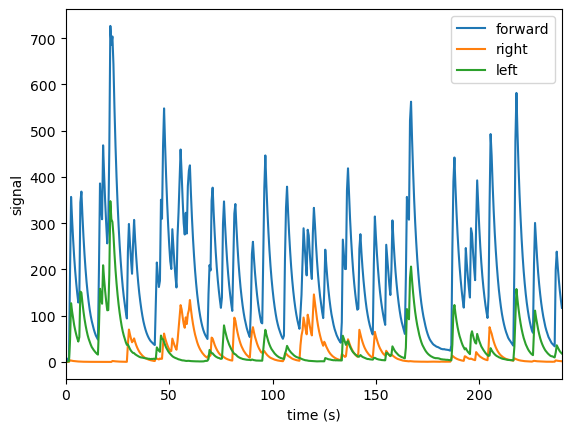

In [322]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,signal_forward,label='forward')
ax.plot(brain_times,signal_right,label='right')
ax.plot(brain_times,signal_left,label='left')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

We've seen that most neurons correlated with stimulus speed have a strong activation on the first trial.

We can try to find how different neurons encode the surprise of the first unexpected trial, the presence of the stimulus and its speed, by defining three different regressor: one that is only active on the first trial, one active on all trials and one proportional to the speed of the stimulus.

In [323]:
signal_speed=convolve_and_interpolate(stimulus_speed,stimulus_times,brain_times)

stimulus=np.copy(stimulus_speed)
stimulus[stimulus_speed>0]=1
signal_stimulus=convolve_and_interpolate(stimulus,stimulus_times,brain_times)

first_trial=np.copy(stimulus_speed)
first_trial[stimulus_times>30]=0
signal_first_trial=convolve_and_interpolate(first_trial,stimulus_times,brain_times)

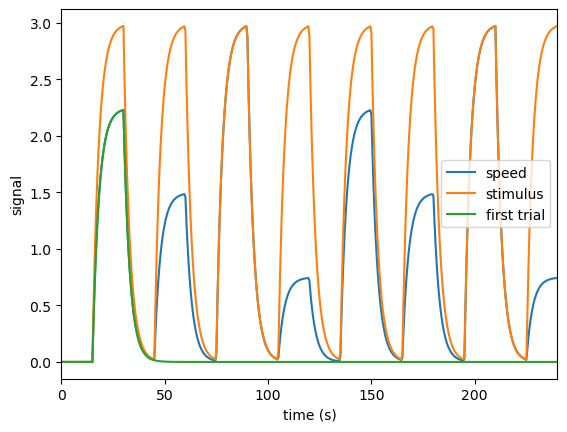

In [324]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,signal_speed,label='speed')
ax.plot(brain_times,signal_stimulus,label='stimulus')
ax.plot(brain_times,signal_first_trial,label='first trial')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

Here we create an array containing all the regressors and we visualize them:

In [325]:
regressors=np.array([scale(signal_speed),scale(signal_stimulus),scale(signal_first_trial)])
#regressors=np.array([scale(signal_forward),scale(signal_right),scale(signal_left)])
#regressors=np.array([scale(signal_forward),scale(signal_stimulus)])
#regressors=np.array([scale(signal_forward),scale(signal_right),scale(signal_left),scale(signal_speed),scale(signal_stimulus),scale(signal_first_trial)])
#regressors=np.array([scale(signal_forward)])

In [326]:
n_regressors=len(regressors)
n_neurons=len(dff)

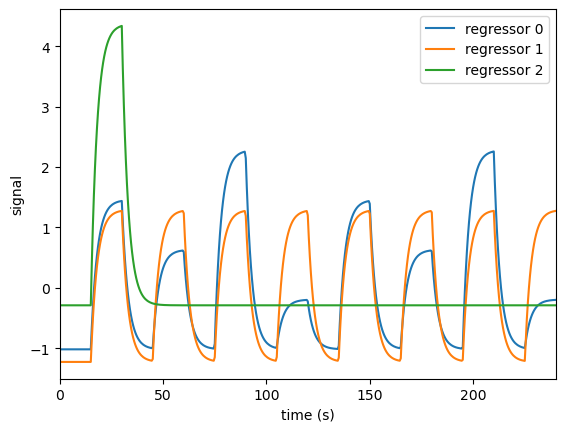

In [327]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
for i,regressor in enumerate(regressors):
    ax.plot(brain_times,regressor,label='regressor '+str(i))
    
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

For each neuron $n$ we assume that the fluorescence $y_n(t)$ can be expressed as a linear combination of the regressors $x_i(t)$ with certain coefficients $\beta_{n,i}$ and some additional noise $\epsilon(t)$:

$$ y_n(t) = \sum_{i} \beta_{n,i} x_i(t) + \epsilon(t)$$

Then we can find the coefficients of best fit $\hat \beta_{n,i}$ for each neuron using the scikit-learn library:

In [328]:
reg=LinearRegression().fit(regressors.T,dff.T)
coef=reg.coef_

And look at the values of the weights for the three regressors across the brain by plotting the neurons with a colormap that encodes positive values in red and negative ones in blue:

In [329]:
plot_coefficients(coords,coef)

interactive(children=(IntSlider(value=0, description='regressor', max=2), Output()), _dom_classes=('widget-int…

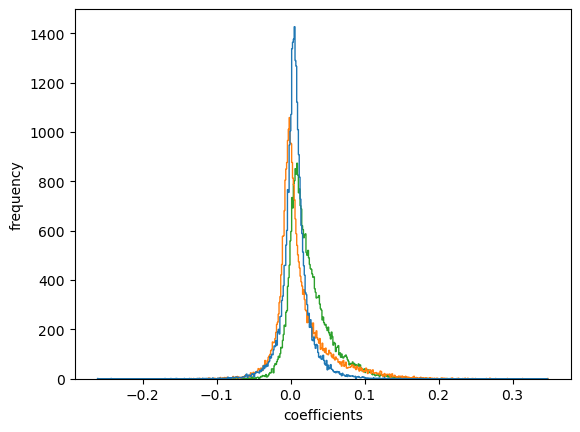

In [330]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(coef,bins='auto',histtype='step')
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

Now we can evaluate the coefficients of determination $R^2$ for each neuron, they're a meausure of how good the fit is.  It's the fraction of variance in the neural activity that is captured by our linear model:

$$ R^2_n = 1 - \frac{\sum_{t}(y_n-\sum_{i} \hat \beta_{n,i} x_i)^2}{\sum_{t}(y_n-\bar y_n)^2} $$

In [331]:
r2=r2_score(dff.T,reg.predict(regressors.T),multioutput='raw_values')

And we look at their distribution in the brain, larger values are darker shades of blue:

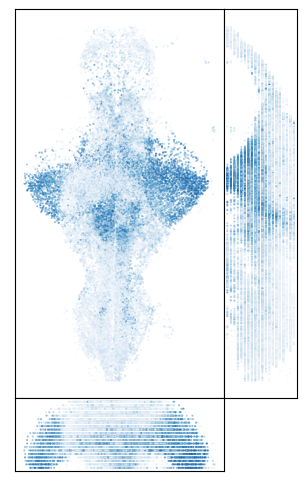

In [332]:
fig=plt.figure(figsize=(6,6),dpi=dpi)
ortho=OrthoAxes(fig,coords,interactive=0)
ortho.scatter(coords,c=r2,cmap='Blues',vmin=0,vmax=1,alpha=0.5,s=2)
plt.show()

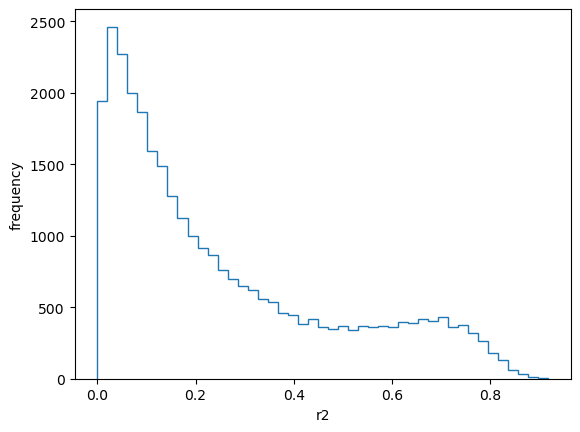

In [333]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(r2,bins='auto',histtype='step')
ax.set_xlabel('r2')
ax.set_ylabel('frequency')
plt.show()

Now we would like to find the neurons whose activity is well fitted by our linear model.  To find the $R^2$ values that are significantly different from zero we can again use the stationary bootstrap to create new samples of brain activity with a scrambled temporal structure and see how our model performs.

In [334]:
n_resamples=20
average_block_duration=30
coef_sbs=np.zeros((n_resamples*n_neurons,n_regressors))
r2_sbs=np.zeros(n_resamples*n_neurons) 

for n in range(n_resamples):
    dff_resampled=stationary_bootstrap(dff.T,average_block_duration*brain_acquisition_rate).T
    reg=LinearRegression().fit(regressors.T,dff_resampled.T)
    coef_sbs[n*n_neurons:(n+1)*n_neurons]=reg.coef_    
    r2_sbs[n*n_neurons:(n+1)*n_neurons]=r2_score(dff_resampled.T,reg.predict(regressors.T),multioutput='raw_values')

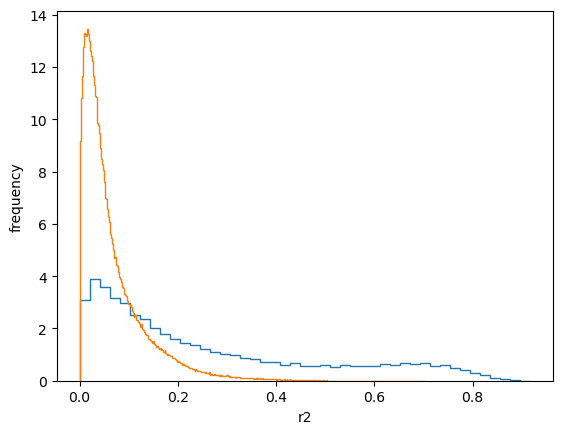

In [335]:
i=0
fig,ax=plt.subplots(dpi=dpi)
ax.hist(r2,bins='auto',histtype='step',density=True)
ax.hist(r2_sbs,bins='auto',histtype='step',density=True)
ax.set_xlabel('r2')
ax.set_ylabel('frequency')
plt.show()

We use the Benjamini–Hochberg procedure once again to find the neurons for which $R^2$ is significantly larger than 0: 

In [336]:
indices_significant,mask_significant=find_significant_neurons(r2,r2_sbs)

In [337]:
len(indices_significant)

7423

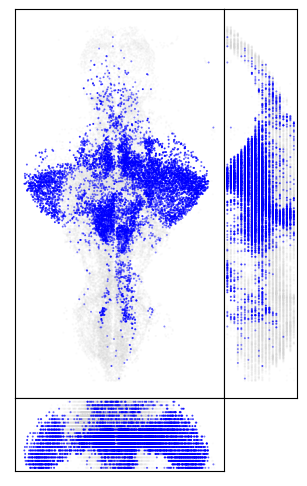

In [338]:
plot_brain_projections(coords,mask_significant,r2)

We can look again at the value of the coefficients, but now just for the neurons for which the linear fit is significant:

In [339]:
plot_coefficients(coords,coef,mask_significant)

interactive(children=(IntSlider(value=0, description='regressor', max=2), Output()), _dom_classes=('widget-int…

Now, we would like to find which combination of regressors is important for fitting the activity of each one of these neurons.

We can estimate the uncertainties on the regression coefficient by using again a bootstrap method.
This time we create new sets of (regressors,fluorescences) values by resampling them with replacement, here we don't care about preserving short term temporal structure in the data as we're keeping together values of regressors and fluorescences that correspond to the same time point. Therefore we don't have to use the stationary bootstrap, but a simple resampling.
Then we can perform linear regression again on each of these resampled sets to obtain new estimates of the coefficients.
Finally we can calculate the standard error of the coefficients as the sample standard deviation of the bootstrapped coefficient values

In [340]:
def bootstrap(array):
    return array[np.random.randint(len(array),size=len(array))]

In [341]:
%%time
n_resamples=100
coef_bs=np.zeros((n_resamples,n_neurons,n_regressors))
samples=np.concatenate([regressors,dff])

for n in range(n_resamples):
    resampled=bootstrap(samples.T).T
    reg=LinearRegression().fit(resampled[:n_regressors].T,resampled[n_regressors:].T)
    coef_bs[n]=reg.coef_

CPU times: user 2min 2s, sys: 34.8 s, total: 2min 37s
Wall time: 49 s


In [342]:
coef_se=np.zeros_like(coef)
for i in range(n_neurons):
    coef_se[i]=np.sqrt(n_resamples/(n_resamples-1))*np.std(coef_bs[:,i,:],axis=0,ddof=1)

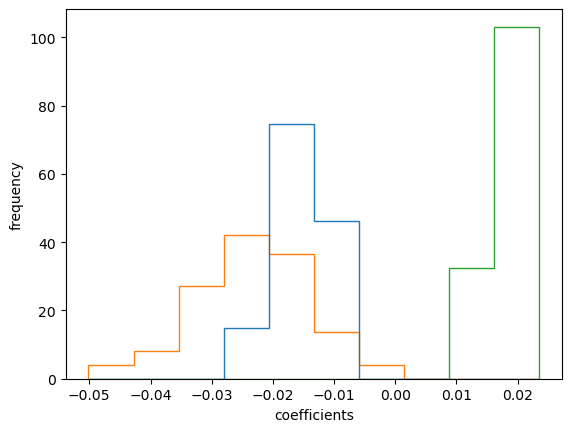

In [343]:
n=10000
fig,ax=plt.subplots(dpi=dpi)
ax.hist(coef_bs[:,n],bins='auto',histtype='step',density=True)
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

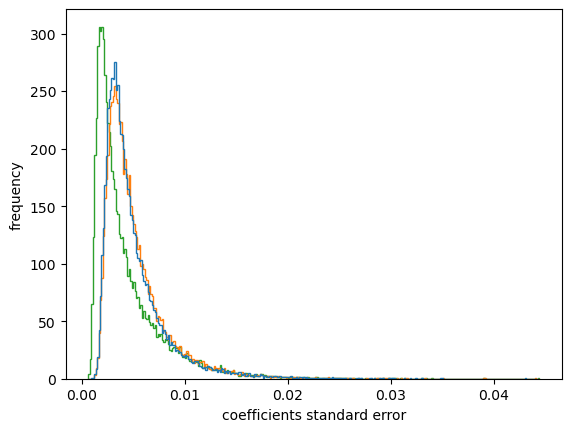

In [344]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(coef_se,bins='auto',histtype='step',density=True)
ax.set_xlabel('coefficients standard error')
ax.set_ylabel('frequency')
plt.show()

Now we'll create a label for each neuron in order to summarize the results of the multiple linear regression. For each regressor we assign $0$ if the corresponding coefficient is not significantly different from 0 (by comparing it with its standard error). For coefficients that are significantly different from 0 we assign $1$ if the coefficient is positive and $-1$ if it's negative.

In [345]:
n_sigma=2
coef_sign=np.zeros_like(coef)
for i in range(n_regressors):
    coef_sign[np.abs(coef[:,i])<n_sigma*coef_se[:,i],i]=0
    coef_sign[coef[:,i]>n_sigma*coef_se[:,i],i]=1
    coef_sign[coef[:,i]<-n_sigma*coef_se[:,i],i]=-1
coef_sign=coef_sign[indices_significant]

Then we can group the neurons using these labels and look at the frequency of each combination in the brain:

In [141]:
sign_combinations=list(itertools.product([0,1,-1],repeat=n_regressors))
sizes=[]
labels=[]
for sign_combination in sign_combinations:
    sizes.append(np.sum(np.all(coef_sign==sign_combination,axis=1)))
    labels.append(str(sign_combination))
sizes=np.array(sizes)
labels=np.array(labels)

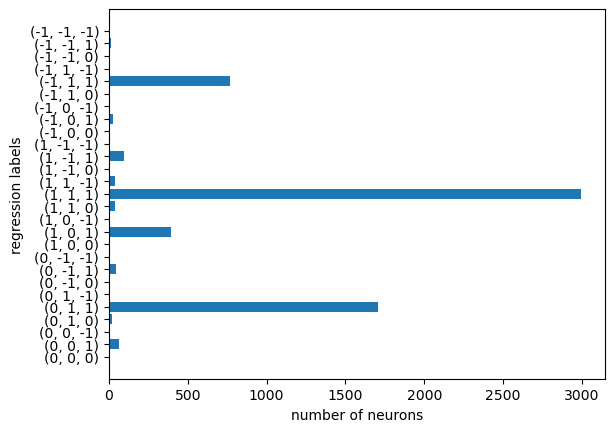

In [142]:
min_size=0
fig,ax=plt.subplots(dpi=dpi)
ax.barh(labels[sizes>=min_size],sizes[sizes>=min_size])
ax.set_xlabel('number of neurons')
ax.set_ylabel('regression labels')
plt.show()

In [143]:
idx=np.argsort(sizes)
labels_sorted=labels[idx]
sizes_sorted=sizes[idx]

In [177]:
labels[np.argsort(sizes)[-1]]

'(1, 1, 1)'

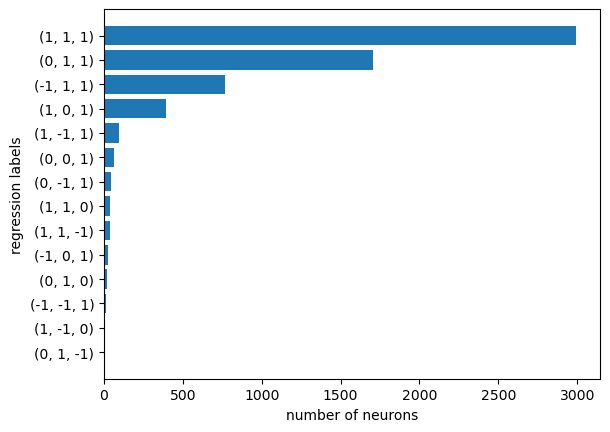

In [144]:
min_size=5
fig,ax=plt.subplots(dpi=dpi)
ax.barh(labels_sorted[sizes_sorted>=min_size],sizes_sorted[sizes_sorted>=min_size])
ax.set_xlabel('number of neurons')
ax.set_ylabel('regression labels')
plt.show()

Now for each combination we can plot the position of the neurons with that label in the brain and their average activity:

In [181]:
plot_neurons_per_label(coef_sign,indices_significant,r2,regressors,coords,dff,brain_times)

interactive(children=(Text(value='(1, 1, 1)', description='combination'), Output()), _dom_classes=('widget-int…

We can also look at the activity of each individual neuron with a particular label:

In [182]:
sign_combination=(0,1,0)
indices_significant_label=indices_significant[np.all(coef_sign==sign_combination,axis=1)]

In [183]:
plot_dff_traces(regressors.T,brain_times,indices_significant_label,dff)

interactive(children=(IntSlider(value=0, description='neuron', max=16), Output()), _dom_classes=('widget-inter…

## Decoding:

We've seen how to model the activity of single neurons as a combination of external signals.

Now we want to explore how to decode external signal from the activity of the whole brain.

We'll try to apply again linear regression but this time we'll be using the activity of all neurons as regressors to try and estimate an external signal.

In [221]:
model=LinearRegression().fit(dff.T,stimulus_T)
coef=model.coef_

In [222]:
r2_score(stimulus_T,model.predict(dff.T))

1.0

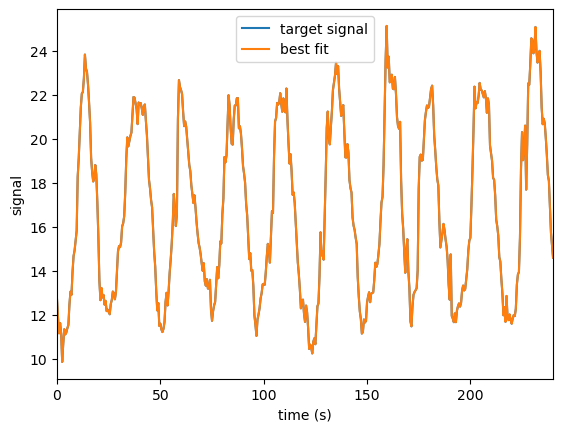

In [223]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,stimulus_T,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

It's a perfect fit... And it's problematic because we're fitting a signal that doesn't have anything to do with our experiment.

This phenomenon is called overfitting, we're able to fit any kind of signal because we have many more regressors (number of neurons ~ 30000) than data points (number of time points ~ 500). 

In order to test whether our model is good we should use only a part of the data points (training set) to obtain its parameters and then test how it performs on the remaining datapoints that we left out  (test set).

Let's try to fit the model on the first 80% of the signal and see how it performs on the remaining 20%:

In [224]:
n_neurons=len(dff)
n_timepoints=len(brain_times)

In [225]:
fraction_train=0.8
idx=int(fraction_train*len(brain_times))

In [226]:
X_train=dff.T[:idx]
X_test=dff.T[idx:]
y_train=stimulus_T[:idx]
y_test=stimulus_T[idx:]

In [227]:
model=LinearRegression().fit(X_train,y_train)
coef=model.coef_

In [228]:
r2_score(y_train,model.predict(X_train))

1.0

In [229]:
r2_score(y_test,model.predict(X_test))

-0.018586162523314353

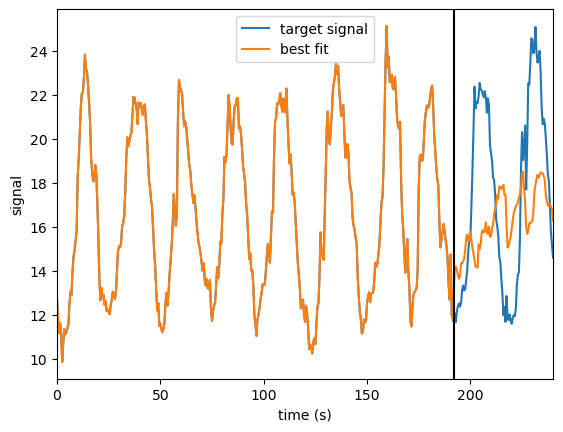

In [230]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,stimulus_T,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')
ax.axvline(brain_times[idx],color='k')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

As expected it doesn't work for predicting the second half of the experiment, it's reassuring!

Now let's try to do the same but with a relevant target signal, the strength of the tail movement:

In [266]:
signal_forward=scale(convolve_and_interpolate(tail_forward_thrust,tail_times,brain_times))

In [267]:
X_train=dff.T[:idx]
X_test=dff.T[idx:]
y_train=signal_forward[:idx]
y_test=signal_forward[idx:]

In [268]:
model=LinearRegression().fit(X_train,y_train)
coef=model.coef_

In [269]:
r2_score(y_train,model.predict(X_train))

1.0

In [270]:
r2_score(y_test,model.predict(X_test))

0.9638216329656849

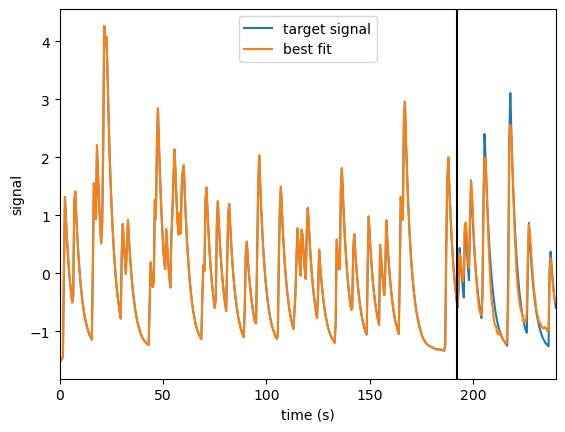

In [244]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,signal_forward,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')
ax.axvline(brain_times[idx],color='k')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

It's much better but we're still overfitting the training set, in order to prevent this we'll have to use a technique called regularization.

It consists in adding some constraints on the coefficients in order to reduce the freedom that allows the model to adapt too much to the training set.

In practice we're going to introduce a term in our optimization problem that penalizes large values of the coefficients.
Based on the specific functional form of this term we can have different results, two popular choices are the L2 (ridge) and the L1 (lasso) regulazion, corresponding to the square and the absolute value of the weights respectively.

In our case the L1 is a good choice as it forces many coefficient to be exactly zero, and we expect many neurons to be irrelevant in encoding the target signal.

Instead in our current model all neurons contribute to the linear combination, to get an idea we can visualize the distribution of weights in the brain:

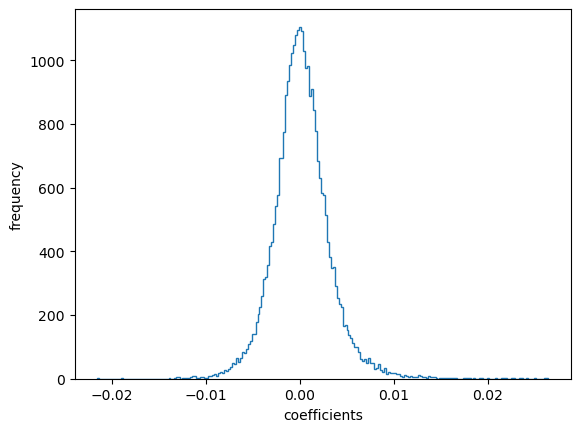

In [245]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(coef[coef!=0],bins='auto',histtype='step')
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

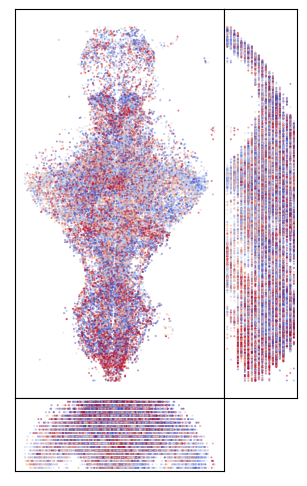

In [250]:
plot_coefficients(coords,coef)

Adding a regularization means also adding an additional parameter $\alpha$ which tunes the strength of the contraint.

It's usually called a hyperparameter, meaning that it's not obtained from the data but we have to fix it ourselves.

In order to choose a suitable value we can fit several model with different $\alpha$s and then choose the one that performs better.

It would be cheating to use the test set to decide the best value of $\alpha$, as we're using the test set to decide the performance of our model.

Therefore we're going to divide our training set further in two and create a validation set on which we can evaluate the model for different values of $\alpha$s.


In [122]:
fraction_valid=0.2
idx=int((1-fraction_valid)*len(y_train))

In [123]:
X_train_alpha=X_train[:idx]
X_valid_alpha=X_train[idx:]
y_train_alpha=y_train[:idx]
y_valid_alpha=y_train[idx:]

In [168]:
alphas=np.logspace(-5,0,10)
alphas=np.logspace(-5,-1,10)
r2s_valid=np.zeros_like(alphas)
n_nonzeros=np.zeros_like(alphas)

for i,alpha in enumerate(alphas):
    print(i)
    model=Lasso(alpha=alpha,max_iter=10000,tol=1e-3).fit(X_train_alpha,y_train_alpha)
    r2s_valid[i]=r2_score(y_valid_alpha,model.predict(X_valid_alpha))
    n_nonzeros[i]=(model.coef_!=0).sum()

0
1
2
3
4
5
6
7
8
9


Let's look at the $R^2$ the validation set in order to choose the best value of $\alpha$:

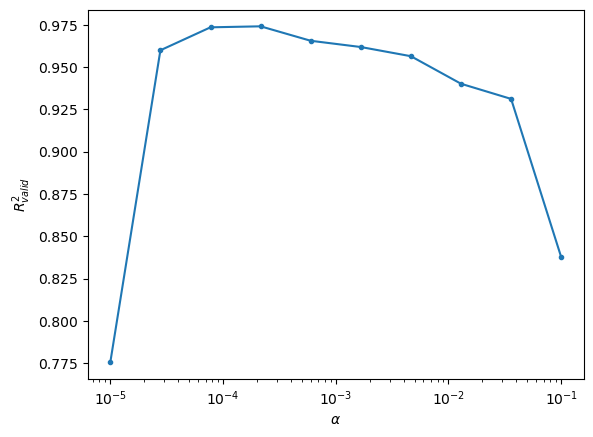

In [169]:
fig,ax=plt.subplots(dpi=dpi)
ax.plot(alphas,r2s_valid,'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$R^2_{valid}$')
plt.show()

We can also have a look at the number of non-zero coefficients and see that they decrease as the strength of the regularization increases as expected:

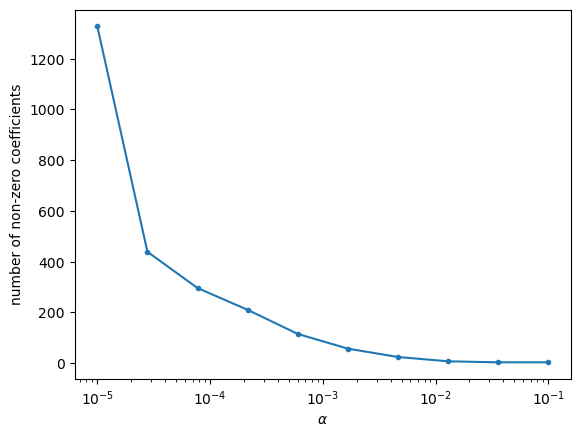

In [171]:
fig,ax=plt.subplots(dpi=dpi)
ax.plot(alphas,n_nonzeros,'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('number of non-zero coefficients')
plt.show()

In [265]:
np.max(r2s_valid)

NameError: name 'r2s_valid' is not defined

In [173]:
best_alpha=alphas[np.argmax(r2s_valid)]
best_alpha

0.00021544346900318823

Now we can finally train our model on the whole training set with our chosen value for $\alpha$ and see how it performs on the test set:

In [174]:
model=Lasso(alpha=best_alpha,max_iter=10000,tol=1e-3).fit(X_train,y_train)
coef=model.coef_

In [175]:
r2_score(y_train,model.predict(X_train))

0.9982797366244354

In [176]:
r2_score(y_test,model.predict(X_test))

0.9687579965696124

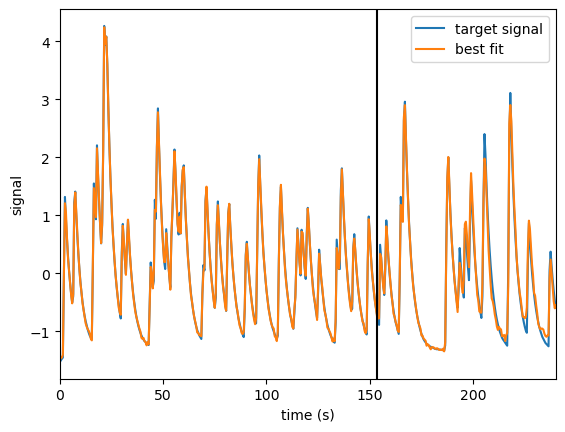

In [178]:
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots(dpi=dpi)
ax.plot(brain_times,signal_forward,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')
ax.axvline(brain_times[idx],color='k')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

And we can look at the distribution of the coefficients in the brain:

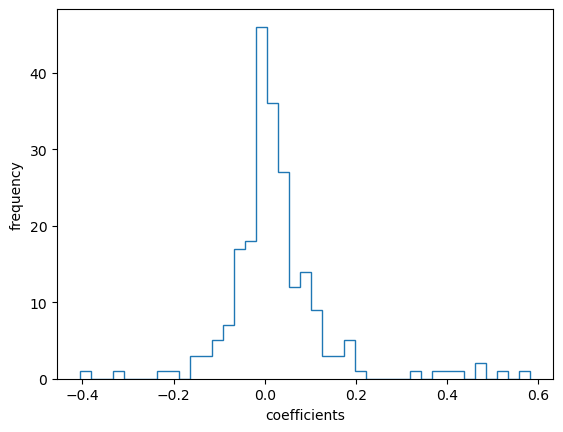

In [180]:
fig,ax=plt.subplots(dpi=dpi)
ax.hist(coef[coef!=0],bins='auto',histtype='step')
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

In [272]:
mask=np.zeros(len(dff))
mask[coef!=0]=1
mask=mask.astype(bool)

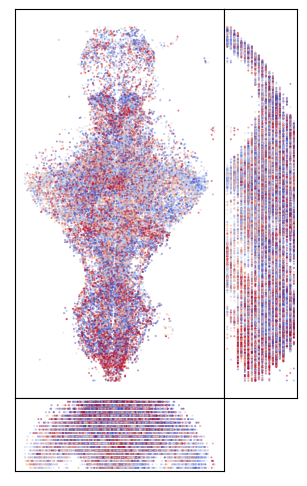

In [273]:
plot_coefficients(coords,coef,mask)